In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import astropy
from astropy import units as u
from astropy.table import Table
from astropy.time import Time

import lightkurve as lk

from tqdm import tqdm_notebook

import glob, os

import tensorflow as tf

plt.rcParams['font.size'] = 20

import exoplanet as xo


# Z Indi Data Analysis

A notebook to study the interesting eclipsing binary Z Indi.

First, download the data using `lightkurve`:

In [40]:
name = "Z Ind"
search = lk.search_lightcurvefile("Z Ind",exptime=120)

/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/3827273588.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search = lk.search_lightcurvefile("Z Ind",exptime=120)


Plot it:

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

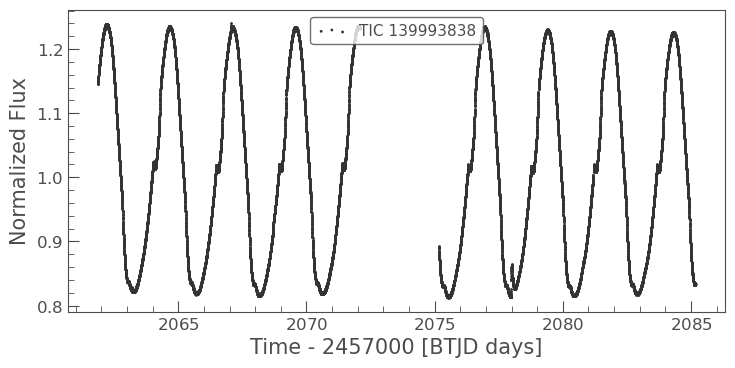

In [41]:
lc = search[0].download().remove_nans().remove_outliers().normalize()
lc = lc[lc.quality == 0]
lc.scatter()
# plt.axvline(2064.2 + 2.4639548974948435)
# plt.xlim(2063,2065)
# plt.xlim(2064,2067)


We can see a high amplitude periodic variation, with little dips. I wonder what those are?

(0.95, 1.02)

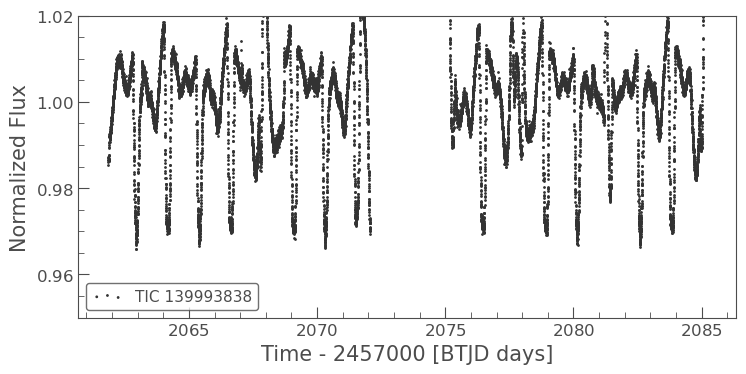

In [42]:
lc.flatten(window_length=800).scatter()
plt.ylim(0.95,1.02)


Eclipses! Let's try and nail down the frequency so we can fold the light curve.

Best period: 2.4639548974948435 d
Best frequency: 0.405851584790258 1 / d


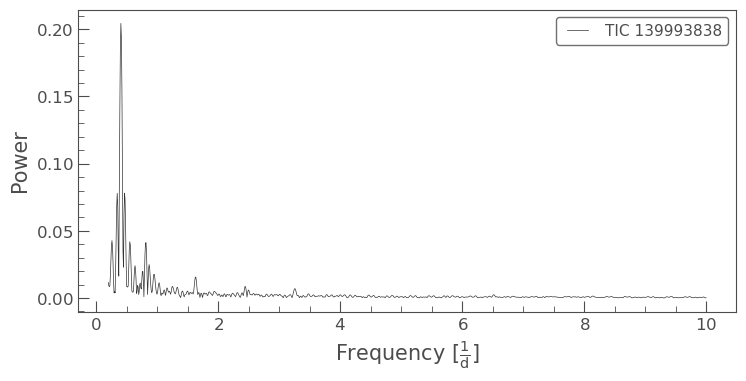

In [43]:
pg = lc.to_periodogram(minimum_frequency=0.2,maximum_frequency=10)
pg.plot()
print('Best period:',pg.period_at_max_power.to(u.d))
print('Best frequency:',pg.frequency_at_max_power)

Let's try and fit out the periodic variations using a GP.

In [44]:
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))


In [45]:
# Normalize around zero for GP fitting.  Keep in units of relative flux, rather
# than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu


In [46]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

from astropy import units as units, constants as const


In [47]:
# solar units
rstar = 35.9
Mstar = 2.6

# si units
Msun = 1.98847e30 # kg
Rsun = 696340e3 # km
G = 6.67430e-11 # si

# cgs units
Msun = 1.98847e30*1e3 # g
Rsun = 696340e3*1e2 # cm
G = 6.67430e-8 # cgs

logg_star = np.log10(G*Mstar*Msun/(rstar*Rsun)**2)
g_sun = G*Msun/Rsun**2
logg_sun = np.log10(g_sun)


In [48]:
logg_star

1.742066531336291

Code snippet from DFM's `exoplanet` docs:

In [11]:
def build_model(mask=None, start=None):
    # https://gallery.exoplanet.codes/tutorials/lc-gp-transit/

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    with pm.Model() as model:

        # Shared parameters
        mean = pm.Normal("mean", mu=0, sd=1, testval=0)

        # Stellar parameters.  These are usually determined from spectroscopy
        # and/or isochrone fits.
        logg_star = pm.Normal("logg_star", mu=1.74, sd=0.1)
        r_star = pm.Normal("r_star", mu=35.9, sd=0.1) # http://www.isthe.com/chongo/tech/astro/HR-temp-mass-table-bymass.html

        # Here "factor" is defined s.t. factor * 10**logg / r_star = rho
        factor = 5.141596357654149e-05
        rho_star = pm.Deterministic(
            "rho_star", factor * 10**logg_star / r_star
        )

        # Limb-darkening: adopt Kipping 2013.
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # To get Rp/R*, fit for log(depth).  This requires an impact parameter
        # prior from 0 to 1, because otherwise there's a sqrt(1-b^2) in the
        # conversion that doesn't make sense.  See
        # https://github.com/exoplanet-dev/exoplanet/blob/e99d1bd68654f21efbbf8400a83889a470d2baf7/src/exoplanet/light_curves/limb_dark.py#L73

        b = pm.Uniform("b", lower=0, upper=1)

        log_depth = pm.Normal("log_depth", mu=np.log(0.05), sigma=1)
        depth = pm.Deterministic("depth", tt.exp(log_depth))

        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(depth, b),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        # Orbital parameters for the planet.  Use mean values from Holczer+16.
        t0 = pm.Normal("t0", mu=2064.2, sd=0.05, testval=2064.2)
        period = pm.Normal("period", mu=2.4639548974948435, sd=0.01, testval=2.4639548974948435)

        # Let the eccentricity float, and use the eccentricity distribution
        # from https://arxiv.org/abs/1807.00549 as our prior.
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=False, shape=1, fixed=True, observed=ecc
        )
        # Alternative choice:
        # xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Define the orbit model.
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            b=b,
            rho_star=rho_star,
            r_star=r_star,
            ecc=ecc,
            omega=omega,
        )

        transit_model = mean + tt.sum(
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
            axis=-1,
        )

        # Convenience function for plotting.
        pm.Deterministic(
            "transit_pred",
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
        )

        # Use the GP model from the stellar variability tutorial at
        # https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sd=2)

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5)
        )
        # Rotation period is 2.6 days, from Lomb Scargle
        log_prot = pm.Normal("log_prot", mu=np.log(2.4639548974948435), sd=0.02)
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)

        # Set up the Gaussian Process model. See
        # https://celerite2.readthedocs.io/en/latest/tutorials/first/ for an
        # introduction. Here, we have a quasiperiodic term:
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        #
        # Note mean of the GP is defined here to be zero, so our "observations"
        # will need to subtract the transit model.  The inverse choice could
        # also be made.
        #
        gp = GaussianProcess(
            kernel,
            t=x[mask],
            diag=yerr[mask] ** 2 + tt.exp(2 * log_jitter),
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("transit_obs", observed=y[mask] - transit_model)

        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(y[mask] - transit_model))

        # Track planet radius in Jovian radii
        r_planet = pm.Deterministic(
            "r_planet",
            (ror * r_star) * (1 * units.Rsun / (1 * units.Rjup)).cgs.value,
        )

        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                log_depth,
                b,
                ecc,
                omega,
                t0,
                period,
                r_star,
                logg_star,
                u_star,
                mean,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln




Optimize this for a maximum a posteriori estimate of the eclipsing binary parameters:

In [12]:
model, map_estimate = build_model()


optimizing logp for variables: [log_dQ, log_Q0, log_prot, f, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: 74298.08940145114 -> 78581.72825394002
optimizing logp for variables: [mean, u_star, logg_star, r_star, period, t0, ecs, b, log_depth]


message: NaN result encountered.
logp: 78581.72825394002 -> 78581.72825394002
optimizing logp for variables: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, ecs, period, t0, log_depth, b, u_star, r_star, logg_star, mean]


message: NaN result encountered.
logp: 78581.72825394002 -> 78581.72825394002


Convenience functions for plotting:

In [13]:
def plot_light_curve(x, y, soln, mask=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    ax = axes[0]

    if len(x[mask]) > int(2e4):
        # see https://github.com/matplotlib/matplotlib/issues/5907
        mpl.rcParams["agg.path.chunksize"] = 10000

    ax.scatter(
        x[mask],
        y[mask],
        c="k",
        s=0.5,
        rasterized=True,
        label="data",
        linewidths=0,
        zorder=42,
    )
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(
        x[mask], gp_mod, color="C2", label="MAP gp model", zorder=41, lw=0.5
    )
    ax.legend(fontsize=10)
    ax.set_ylabel("$f$")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(
            x[mask],
            mod,
            label="planet {0} [model under]".format(l),
            zorder=-10,
        )
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")

    ax = axes[2]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(x[mask], mod, label="planet {0} [model over]".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
    ymin = np.min(mod) - 0.05 * abs(np.min(mod))
    ymax = abs(ymin)
    ax.set_ylim([ymin, ymax])

    ax = axes[3]
    mod = gp_mod + np.sum(soln["transit_pred"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()


/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/2102508602.py:54: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin, ymax])


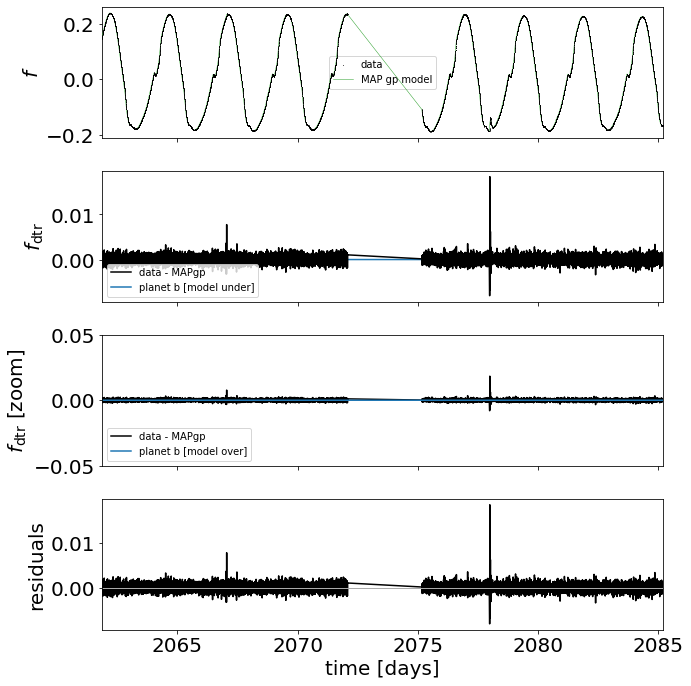

In [14]:
plot_light_curve(x, y, map_estimate)


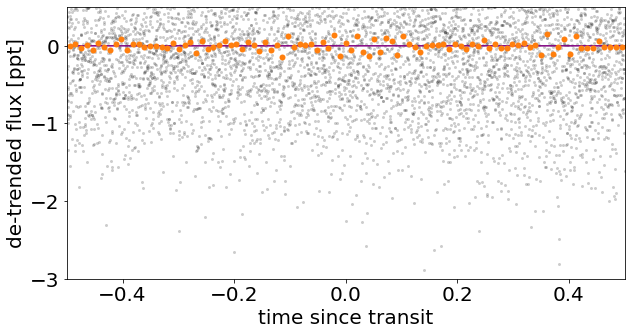

In [15]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))

# Ephemeris from Holczer+16
t0 = 2064.2
period = 2.4639548974948435

x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (y[m] - map_estimate["gp_pred"][m]),
    c="k",
    marker=".",
    alpha=0.2,
    linewidths=0,
)

lc_mod = map_estimate["transit_pred"][:, 0]
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody + map_estimate["mean"]), c="purple", zorder=1)

# Overplot the phase binned light curve
bins = np.linspace(-0.51, 0.51, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y - map_estimate["gp_pred"])
denom[num == 0] = 1.0
ax.scatter(
    0.5 * (bins[1:] + bins[:-1]),
    1e3 * num / denom,
    color="C1",
    zorder=2,
    linewidths=0,
)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-3, 0.5)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")


Well that didn't work. Might have to do this by hand!

In [16]:
from astropy.timeseries import LombScargle

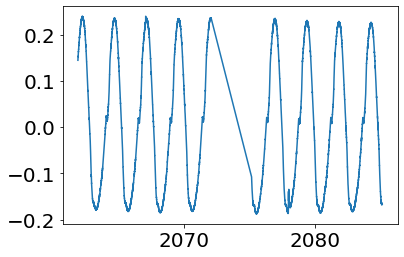

In [17]:
plt.plot(x,y)

Use a Lomb-Scargle to fit a sum of sine waves:

In [18]:
LS = LombScargle(x,y,yerr,nterms=2)

In [19]:
freqs = np.linspace(1/3,1/2,10000)
power = LS.power(freqs)
# plt.plot(1/freqs,power)
period = 1/freqs[np.argmax(power)]
print(period,'d')


2.4562538382804506 d


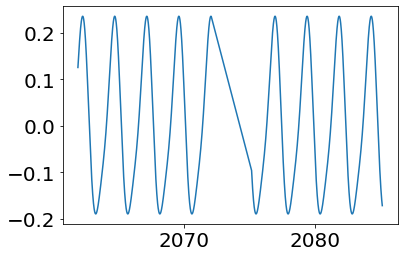

In [20]:
model = LS.model(x,freqs[np.argmax(power)])
plt.plot(x,model)


In [50]:
# fig = plt.figure(figsize=(12.0,8.0))

# plt.plot((x % period)[~flare], y[~flare],'.',label='Data')
# args = np.argsort(x % period)
# plt.plot((x % period)[args],model[args],'-',lw=3,label='Sine Fit')
# plt.xlabel('Phase (d)')
# plt.ylabel('Flux')
# plt.legend()
# plt.savefig('z_ind_sine_fit.png',bbox_inches='tight')

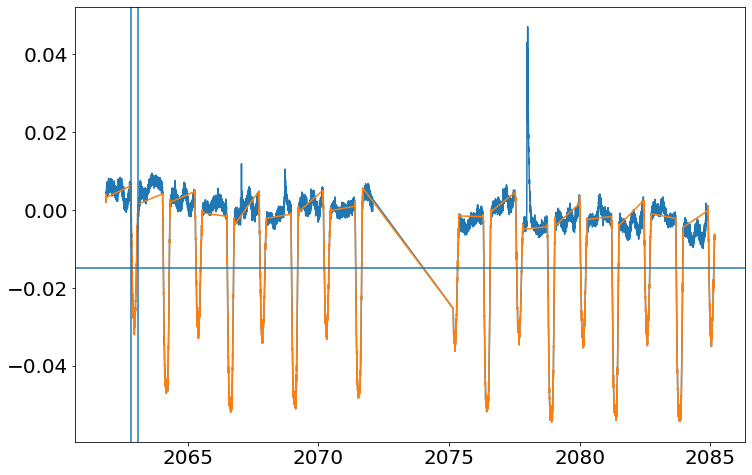

In [51]:
fig = plt.figure(figsize=(12.0,8.0))
t0 = 2062.95
dur = 0.15

m = (((x-t0) % (period/2))<(dur)) + (((x-t0) % (period/2)) > (period/2-dur))

plt.plot(x,y-model)
plt.plot(x[m],(y-model)[m])
plt.axhline(-0.015)
# plt.plot(x,model)
# plt.xlim(2060,2065)

plt.axvline(t0-0.12)
plt.axvline(t0+0.12)


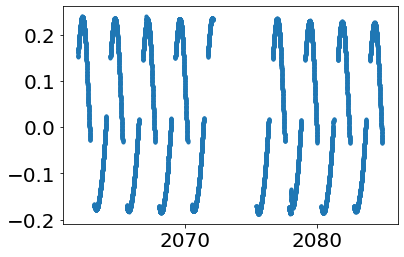

In [52]:
plt.plot(x[~m],y[~m],'.')


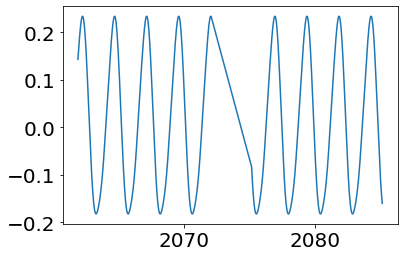

In [53]:
LS = LombScargle(x[~m],y[~m],yerr[~m],nterms=4)
model = LS.model(x,1/period)
plt.plot(x,model)

In [54]:
def normalize(xx):
    return (xx-xx.min())/(xx.max()-xx.min())

basis = np.vander(normalize(x[~m]),3)
soln = np.linalg.lstsq(basis,(y-model)[~m])
# help(np.linalg.lstsq)
coeffs = soln[0]
newbasis = np.vander(normalize(x),3)
trend = np.dot(newbasis,coeffs)


/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/2710143171.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soln = np.linalg.lstsq(basis,(y-model)[~m])


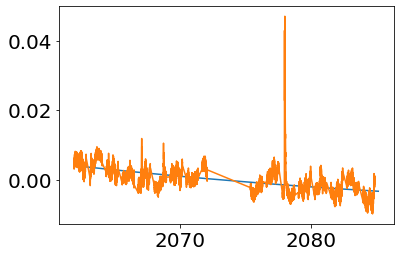

In [55]:
plt.plot(x,trend)
plt.plot(x[~m],(y-model)[~m])

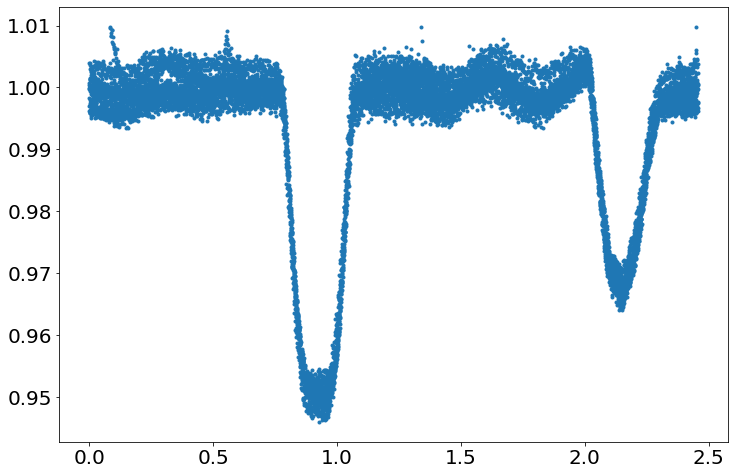

In [56]:
plt.figure(figsize=(12.0,8.0))
flare = (y-model-trend)>0.01
plt.plot((x % period)[~flare], (y-model-trend)[~flare]+1,'.')

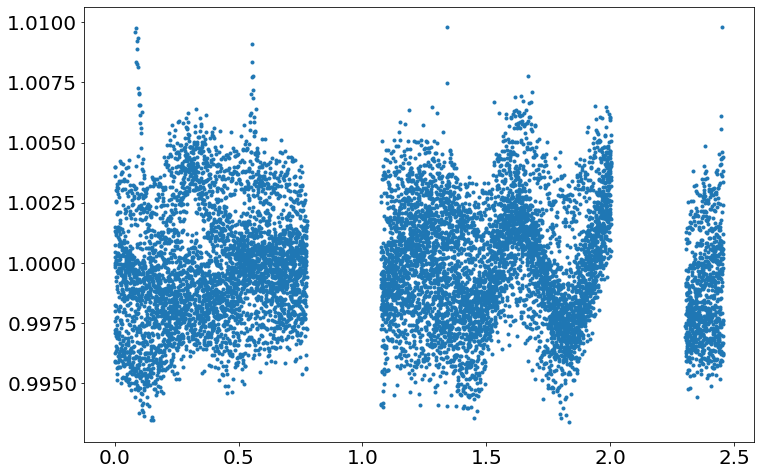

In [57]:
plt.figure(figsize=(12.0,8.0))
flare = (y-model-trend)>0.01
plt.plot((x % period)[~m*~flare], (y-model-trend)[~m*~flare]+1,'.')

Can we fit this with a GP?

In [58]:
import celerite2
from celerite2 import terms

# Quasi-periodic term
# term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.Matern32Term(sigma=0.005, rho=2.0)
kernel = term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(x[~m], yerr=yerr[~m])


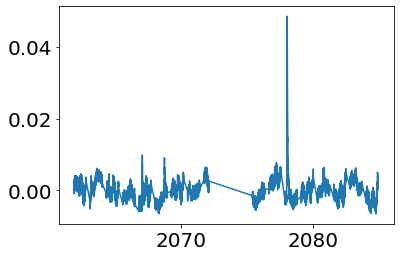

In [65]:
t = x[~m]
newy = (y-model-trend)[~m]
newyerr = yerr[~m]
plt.plot(t,newy)

In [66]:
from scipy.optimize import minimize


def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.Matern32Term(
        sigma=theta[0], rho=theta[1],
    ) 
    gp.compute(t, diag=newyerr**2 + theta[2], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(newy)


initial_params = [0.0, np.log(0.005), np.log(2.0), np.log(0.0001)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln


      fun: -59291.24265536269
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1149.74536701, -3478.31666954,  -371.04837473, -2596.61588987])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 11
     njev: 44
   status: 0
  success: True
        x: array([-8.11239741e-03, -3.87569685e+00, -1.96816440e+00, -1.74485444e+01])

In [67]:
np.exp(soln['x'])

array([9.91920419e-01, 2.07398802e-02, 1.39713078e-01, 2.64358601e-08])

In [68]:
mu, variance = opt_gp.predict(newy, t=x, return_var=True)

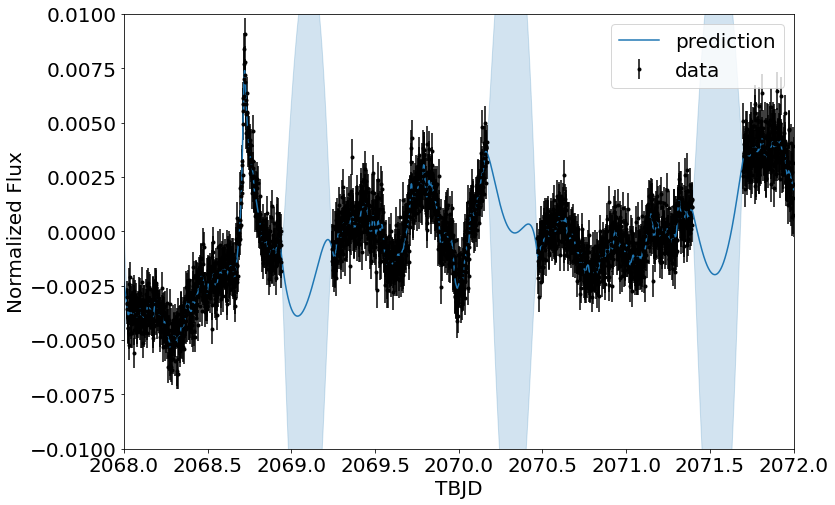

In [69]:
fig = plt.figure(figsize=(12.0,8.0))
plt.errorbar(t, newy, yerr=newyerr, fmt=".k", capsize=0, label="data")

sigma = np.sqrt(variance)
plt.plot(x, mu, label="prediction")
plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)
plt.ylim(-0.01,0.01)
plt.xlim(2068,2072)
plt.legend()

plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
plt.savefig('z_ind_gp.png',bbox_inches='tight')

In [70]:
from scipy.ndimage.filters import gaussian_filter1d as gaussfilt

/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/2359404833.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d as gaussfilt


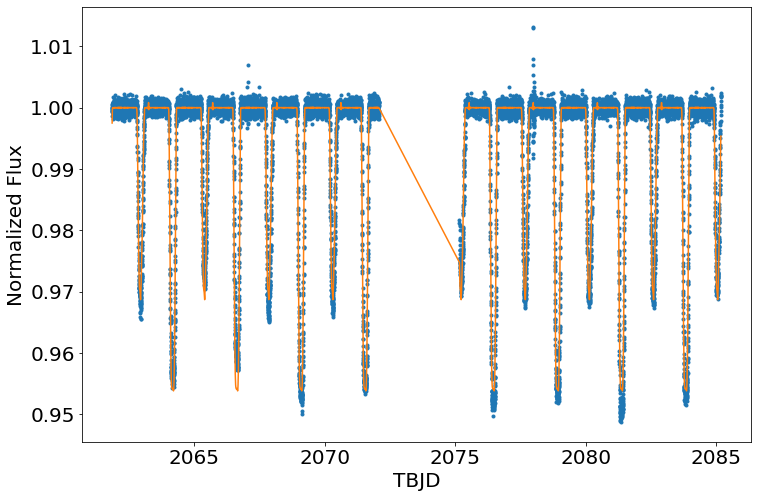

In [72]:
fig = plt.figure(figsize=(12.0,8.0))

t_folded = (x % period)#[~flare]

t_base = (x)
args = np.argsort(t_folded)
t_folded = t_folded
y_unfolded = ((y-model-trend)+1 - mu)

args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_base, y_unfolded,'.')
plt.plot(t_base, smooth[np.argsort(args)],'-')

plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
plt.savefig('z_ind_eclipses.png',bbox_inches='tight')

Text(0, 0.5, 'Normalized Flux')

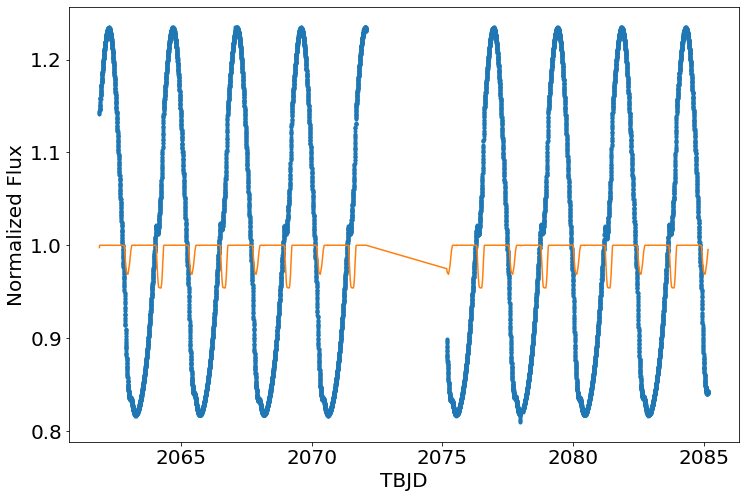

In [73]:
fig = plt.figure(figsize=(12.0,8.0))

t_base = (x)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded
y_unfolded = ((y-trend)+1 - mu)[~flare]

t_folded = (x % period)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_base, y_unfolded,'.')
plt.plot(t_base, smooth[np.argsort(args)],'-')

plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
# plt.savefig('z_ind_eclipses.png',bbox_inches='tight')

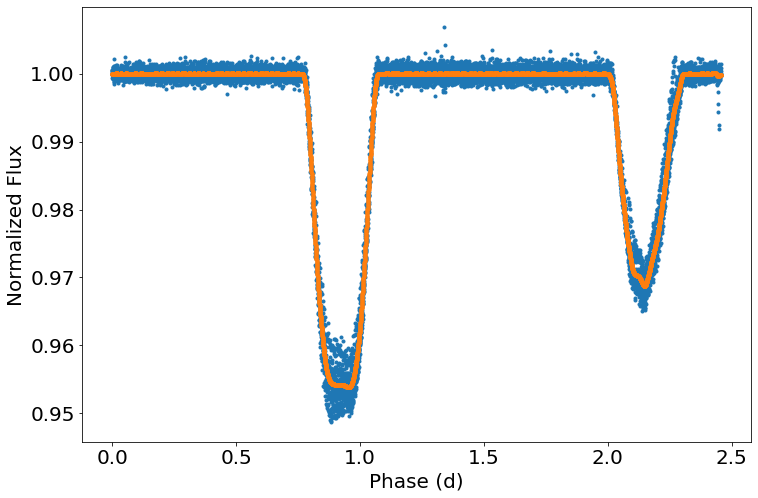

In [74]:
fig = plt.figure(figsize=(12.0,8.0))

t_folded = (x % period)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_folded, y_folded,'.')
plt.plot(t_folded, smooth,'.')
plt.xlabel('Phase (d)')
plt.ylabel('Normalized Flux')
plt.savefig('z_ind_folded.png',bbox_inches='tight')
# plt.axvline(0.925)
# plt.axvline(0.925+period/2)

Wow! What is happening here? Let's look at the implied stellar radii.

In [75]:
depth = (1-np.min(smooth))
print('Deeper eclipse is %.1f%%' % (depth*100))
print('Implies stellar radius of %.1f Rsun' % (np.sqrt(depth)*rstar))

depth = (1-np.min(smooth[t_folded>1.5]))
print('Shallower eclipse is %.1f%%' % (depth*100))
print('Implies stellar radius of %.1f Rsun' % (np.sqrt(depth)*rstar))

Deeper eclipse is 4.6%
Implies stellar radius of 7.7 Rsun
Shallower eclipse is 3.1%
Implies stellar radius of 6.4 Rsun


In [76]:
print('If a dwarf')
print('Implies stellar radius of %.2f Rsun' % (np.sqrt(depth)*0.783))
print('Implies stellar radius of %.2f Rearth' % (np.sqrt(depth)*0.783*109))


If a dwarf
Implies stellar radius of 0.14 Rsun
Implies stellar radius of 15.10 Rearth


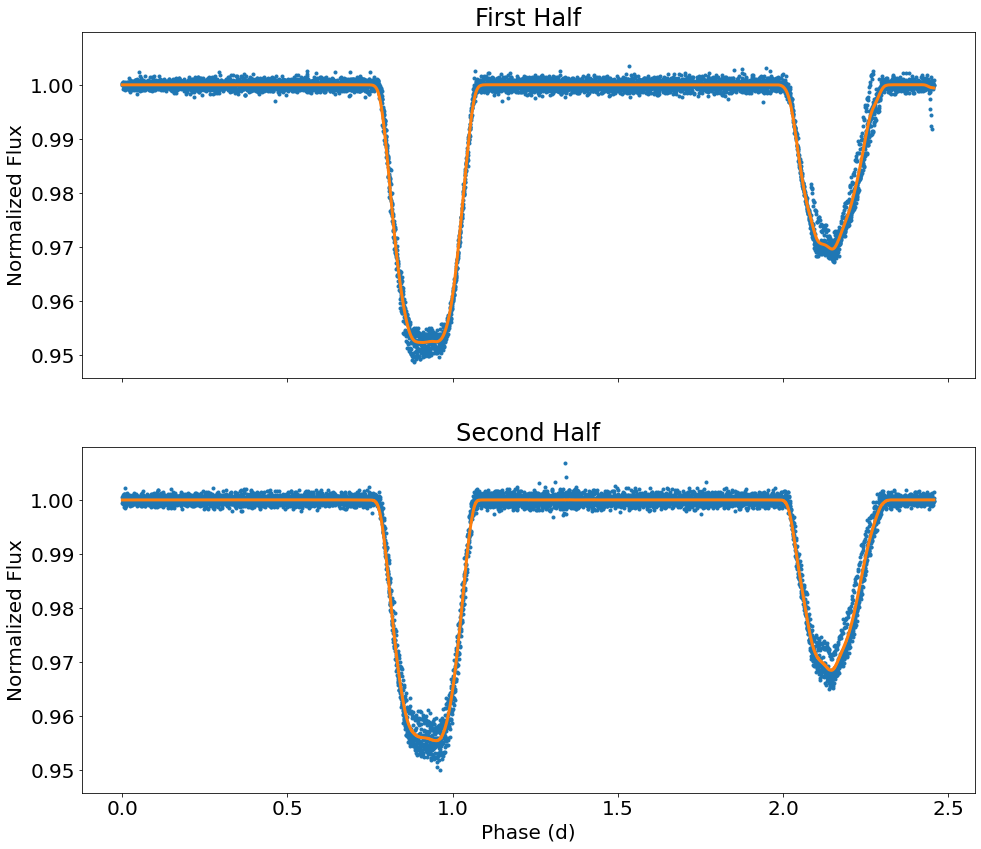

In [77]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16.0,14.0),sharey=True,sharex=True)

first = normalize(x[~flare])>0.5 
t_folded = (x % period)[~flare][first]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][first][args]
smooth = gaussfilt(y_folded,30)

ax1.plot(t_folded, y_folded,'.')
ax1.plot(t_folded, smooth,'-',lw=3)
ax1.set_title('First Half')

t_folded = (x % period)[~flare][~first]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][~first][args]
smooth = gaussfilt(y_folded,30)

ax2.plot(t_folded, y_folded,'.')
ax2.plot(t_folded, smooth,'-',lw=3)
ax2.set_title('Second Half')

ax2.set_xlabel('Phase (d)')
ax1.set_ylabel('Normalized Flux')
ax2.set_ylabel('Normalized Flux')

plt.savefig('z_ind_2_halves.png',bbox_inches='tight')

In [78]:
tpfsearch = lk.search_targetpixelfile('Z Ind',exptime=120)
tpf = tpfsearch.download()

<AxesSubplot:title={'center':'Target ID: 139993838, Cadence: 600765'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

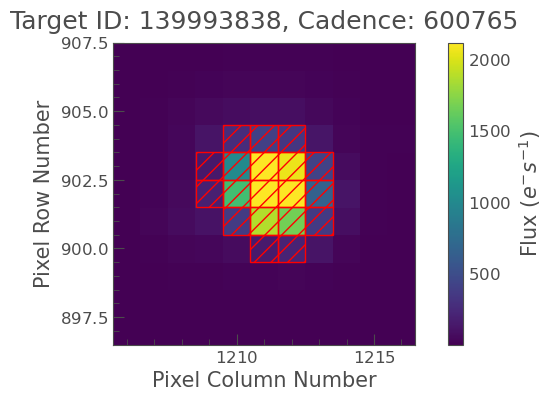

In [ ]:
tpf.plot(aperture_mask='pipeline')

In [ ]:
help(tpf.plot)

Help on method plot in module lightkurve.targetpixelfile:

plot(ax=None, frame=0, cadenceno=None, bkg=False, column='FLUX', aperture_mask=None, show_colorbar=True, mask_color='red', title=None, style='lightkurve', **kwargs) method of lightkurve.targetpixelfile.TessTargetPixelFile instance
    Plot the pixel data for a single frame (i.e. at a single time).
    
    The time can be specified by frame index number (`frame=0` will show the
    first frame) or absolute cadence number (`cadenceno`).
    
    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    frame : int
        Frame number. The default is 0, i.e. the first frame.
    cadenceno : int, optional
        Alternatively, a cadence number can be provided.
        This argument has priority over frame number.
    bkg : bool
        If True and `column="FLUX"`, background will be added to the pixel values.
    colu